Stuff and things

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

***Part i)***

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patch
%matplotlib inline

machInitials = [2,4]

gamma = 1.4
beta = 45
rampAngle = 5 #degrees
dummy = 1
t = 0
DRC = np.pi/180
RDC = 180/np.pi
obliqueValues = []

def obliqueShockCheck(s,M):
    OSC_temp = [np.tan(rampAngle * DRC) * np.tan(s * DRC),
                (((gamma+1)*M**2)/(2*(M**2*(np.sin(s * DRC))**2-1)))-1
               ]
    upstreamOfShockRatio = OSC_temp[0] * OSC_temp[1]
    del(OSC_temp)
    return(upstreamOfShockRatio)

def obliqueShockMach(s,M):
    obliqueMach = []
    #print('s: ' + str(s))
    for j in range(len(M)):
        #print("s: " + str(s[j][0]))
        OSM_temp = [ (np.sin((s[j][0]-rampAngle) * DRC))**2,
                    (gamma - 1)*M[j]**2*(np.sin(s[j][0] * DRC))**2 + 2,
                    2*gamma*M[j]**2*(np.sin(s[j][0] * DRC))**2 - (gamma-1)
                    ]
        obliqueMach.append(np.sqrt((OSM_temp[1]/OSM_temp[2])/OSM_temp[0]))
    del(OSM_temp)
    return(obliqueMach)

def obliqueShock(beta,M):
    #Ensure M input is a list
    try:
        M[0]
    except:
        M = [M]
    #
    dummy = 1
    t = 0
    # For/While loop
    for i in range(len(M)):
        while dummy > t:
            t = obliqueShockCheck(beta,M[i])
            beta -= 0.001
            if beta < 0: break
        obliqueValues.append([beta])
        #reset the values
        beta = 45
        t = 0
        if len(obliqueValues) == len(M):
            valTemp = obliqueShockMach(obliqueValues,M)
            [obliqueValues[x].append(valTemp[x]) for x in range(len(M))]
            del(valTemp)
    return(obliqueValues)
def prandtlMeyer(M):
    PM_temp = [np.sqrt((gamma+1)/(gamma-1)),
               np.arctan(np.sqrt(((gamma-1)/(gamma+1))*(M**2 -1))),
               np.arctan(np.sqrt(M**2 -1))]
    prMach = PM_temp[0] * PM_temp[1] - PM_temp[2]
    del(PM_temp)
    return(prMach * RDC)

#-----------------------------------#
######          MAIN          #######    
#-----------------------------------#

afterShock = obliqueShock(45, machInitials)
beta4 = afterShock[1][0]
M4 = afterShock[1][1]
#print("[beta,mach] for M=2 then M=4 \n" + str(afterShock))
turnAngle = prandtlMeyer(afterShock[0][1])
print("Total flow turning:\n" + str(turnAngle) + " degrees")

#Change angles to radians for remainder of code:
turnAngle = turnAngle * DRC
beta4 = beta4 * DRC
rampAngle = rampAngle * DRC

Total flow turning:
21.342732939749716 degrees


***Part ii)***

In [45]:
## RAMP INITIAL VALUES ##
#Oblique Shock values (on design)
m4ObShockLength = 1/(np.sin(beta4))
muOb = (np.arcsin(1/M4))
nuOb = prandtlMeyer(M4)


#Cowl Coordinates
cowlLip = [np.sqrt(m4ObShockLength**2 - 1),1]

#Random Angles
other = np.pi - muOb
eta = np.pi - other - (beta4 - rampAngle)

#Wedge Coordinates
rampLength = (m4ObShockLength / np.sin(other)) * np.sin(eta)
rampDim = [(rampLength * np.cos(rampAngle)), (rampLength * np.sin(rampAngle))]
wedToCowl = np.sqrt(np.sum([(cowlLip[i] - rampDim[i])**2 for i in range(0,2)]))
rampHat = wedToCowl * np.sin(muOb)
rampH = 1 - rampDim[1]

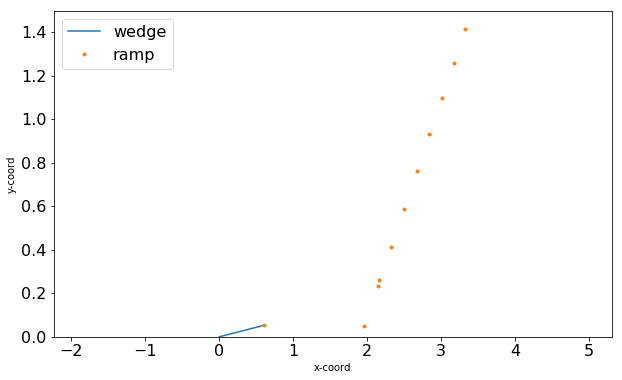

In [36]:
def actualTurning():
    vM4 = prandtlMeyer(afterShock[1][1])
    #print("vM4: " + str(vM4))
    vM2 = turnAngle
    delV = vM4 - vM2
    #print(delV)
    mIter = 2.4
    vIter = vM2
    while vIter < delV:
        vIter = prandtlMeyer(mIter)
        mIter += 0.000001
    return([mIter, vIter])

def delXdelY(M):
    l = []
    hHat = []
    h = []
    y = []
    x = []
    DXDY_temp = [M4/M,
                 2.+(gamma-1)*M**2,
                 2.+(gamma-1)*M4**2,
                 (gamma+1)/(2*(gamma-1))
                ]
    l.append(m4ObShockLength)
    hHat.append(rampHhat)
    h.append(1-rampY)
    y.append(rampY)
    x.append(rampX)
    mu = [(np.arcsin(1/item)*RDC) for item in M]
    nu = [(prandtlMeyer(item)*RDC) for item in M]
    thTurn = [((nu[i-1]-nu[i]) * RDC) for i in range(1,len(nu))]
    #delete first values:
    for i in range(len(mu)):
        if i == 0:
            continue
        DXDY_temp = [M[i-1]/M[i],
                 2.+(gamma-1)*M[i]**2,
                 2.+(gamma-1)*M[i-1]**2,
                 (gamma+1)/(2*(gamma-1))
                    ]
        hHatTemp = ((hHat[i-1]) * (DXDY_temp[0]*(DXDY_temp[1]/DXDY_temp[2])**DXDY_temp[3]))
        lTemp = hHatTemp/(np.sin(mu[i] * DRC))
        phi = mu[i] + thTurn[i-1] + 5
        hTemp = lTemp * np.sin(phi * DRC)
        delX = lTemp * np.sin(phi * DRC)
        xTemp = cowlLipCoord[0] - delX
        yTemp = 1 - hTemp
        #Append actual values
        y.append(yTemp)
        x.append(xTemp)
        hHat.append(hHatTemp)
        l.append(lTemp)
        h.append(hTemp)
        del(yTemp,xTemp,hHatTemp,lTemp,hTemp,delX)
    xy = [[x[i],y[i]] for i in range(len(x))]
    return(xy)
        

'''
def delXdelY(M2,xi,yi):
    mu = np.arcsin(1/M2) * RDC
    nu = prandtlMeyer(M2)
    theta = 5 + nuM4 - nu
    DXDY_temp = [M4/M2,
                 2.+(gamma-1)*M2**2,
                 2.+(gamma-1)*M4**2,
                 (gamma+1)/(2*(gamma-1)),
                 (nuM4 - nu)
                 ]
    #print("variables:" + "\n" + str(DXDY_temp))
    hHat = ((rampHhat) * (DXDY_temp[0]*(DXDY_temp[1]/DXDY_temp[2])**DXDY_temp[3]))
    hVal = ((hHat * np.sin((theta + mu) * DRC))/(np.cos((90-mu) * DRC)))
    #print("hVal: " + str(hVal))
    yVal = 1 - hVal
    delX = (yVal - yi)/(np.tan((rampAngle + DXDY_temp[4]) * DRC))
    print(delX)
    xVal = xi + delX
    del(DXDY_temp,mu,nu,theta)
    return([xVal,yVal])
'''

#-----------------------------------#
######          MAIN          #######    
#-----------------------------------#


## Calculating Actual Turning at Mach 4 ##
actTurn = actualTurning()[0]
#print(actTurn)

mLinRev = np.linspace(actTurn,afterShock[1][1], 100)
#Lin-space for the mach numbers
mLin = [mLinRev[len(mLinRev) - (j+1)] for j in range(len(mLinRev))]
#muLin = [np.arcsin(1/item) * RDC for item in mLin]
#nuLin = [prandtlMeyer(item) for item in mLin]
#thetaLin = [(5 + nuM4 - item) for item in nuLin]
#print("mLin" + str(mLin))
#generate x and y coordinates
xyCoord = delXdelY(mLinRev)


#GRAPHING TIME
plt.figure(figsize=(10,6))
plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16)
#
plt.plot([0,xyCoord[0][0]], [0,xyCoord[0][1]], '-', label="wedge")
plt.plot([item[0] for item in xyCoord], [jtem[1] for jtem in xyCoord], '.', label='ramp')

#plt.title('Mach number to altitude', fontsize=16)

plt.ylim(0,1.5)
plt.xlabel('x-coord')
plt.ylabel('y-coord')
plt.legend(loc=2, fontsize=16)

plt.show()
plt.close()



In [32]:
xyCoord = delXdelY(mLinRev)
print(hHat)
#print("xy Coordinates:\n" + str(xyCoord))

#print(xyCoord)
#print("y1: " + str(xyCoord[1][0]))

#GRAPHING TIME
plt.figure(figsize=(10,6))
plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16)
#
plt.plot([0,xyCoord[0][0]], [0,xyCoord[0][1]], '-', label="wedge")
plt.plot([item[0] for item in xyCoord], [jtem[1] for jtem in xyCoord], '.', label='ramp')

#plt.title('Mach number to altitude', fontsize=16)

plt.ylim(0,1.5)
plt.xlabel('x-coord')
plt.ylabel('y-coord')
plt.legend(loc=2, fontsize=16)

plt.show()
plt.close()

NameError: name 'hHat' is not defined

***Part iii)***

0.6139657259302709
theta: 26.342699994357872
circle
5.645964221705366
-1.1013195869248973

 Checking ArcCos:
3.871007505081134
-0.7227425903680726
---


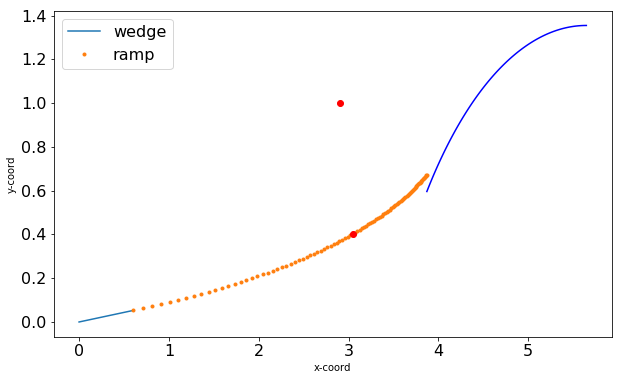

In [8]:
#Finding the closest point on the ramp
lenToCowl = []
for item in xyCoord:
    dis = np.sqrt((item[0] - cowlLipCoord[0])**2 + (item[1] - cowlLipCoord[1])**2)
    lenToCowl.append(dis)
minLen = min(lenToCowl)
minLenIndex = lenToCowl.index(minLen)
closestRamp = [xyCoord[minLenIndex][0], xyCoord[minLenIndex][1]]
print(minLen)

'''
This closest point dictates the duct height, as the rest of the distances will be of equal length going up
the duct. So now we have a radius, R = 4 * duct height, so we draw a circle and adjust it so the arc
only goes up to the horizontal.
'''
#Solving for the parameters of our circle, using the coordinates given
theta = rampAngle + prandtlMeyer(M4) - prandtlMeyer(mLin[-1])
print("theta: " + str(theta))
thetaToCirc = 90-theta
circXCent = xyCoord[-1][0] + (4 * np.cos(thetaToCirc * DRC))
circYCent = xyCoord[-1][1] - (4 * np.cos(thetaToCirc * DRC))
print("circle")
print(circXCent)
print(circYCent)

print("\n Checking ArcCos:")
print(xyCoord[-1][0])

print((xyCoord[-1][0]-circXCent)/(4*minLen))
print("---")
x = np.linspace(np.arccos(((xyCoord[-1][0]-circXCent)/(4*minLen)))-2*np.pi,-((3*np.pi)/2),100)
#print(x)
circX = (4*minLen)*np.cos(x) + circXCent
circY = (4*minLen)*np.sin(x) + circYCent
#GRAPHING TIME

plt.figure(figsize=(10,6))
plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16)
#
plt.plot([0,xyCoord[0][0]], [0,xyCoord[0][1]], '-', label="wedge")
plt.plot([item[0] for item in xyCoord], [jtem[1] for jtem in xyCoord], '.', label='ramp')
plt.plot(closestRamp[0],closestRamp[1],'ro')
plt.plot(cowlLipCoord[0],cowlLipCoord[1],'ro')
plt.plot(circX,circY,'-',color='blue')

#plt.title('Mach number to altitude', fontsize=16)

#plt.xlim(0,6)
#plt.ylim(-2,2)
plt.xlabel('x-coord')
plt.ylabel('y-coord')
plt.legend(loc=2, fontsize=16)

plt.show()
plt.close()